# Smart BSL Room Control System - AI Models

Sistem ini terdiri dari 2 subsistem AI:
1. **Prediksi Kontrol Suhu** - XGBoost untuk mengefisienkan penggunaan daya AC
2. **Deteksi Anomali Kondisi Ruangan** - Isolation Forest untuk early warning system

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


---

## 1. Prediksi Kontrol Suhu (XGBoost Regression)

Subsistem ini menggunakan XGBoost untuk memprediksi kekuatan AC yang optimal berdasarkan kondisi ruangan. Model ini membantu mengefisienkan penggunaan daya AC sambil mempertahankan stabilitas suhu dan level biosafety.

**Features:**
- `temp`: Suhu ruangan saat ini (°C)
- `hum`: Kelembaban relatif (%)
- `temp_outdoor`: Suhu luar ruangan (°C)
- `occupancy`: Jumlah orang dalam ruangan
- `time_of_day`: Waktu dalam hari (0-23)

**Target:**
- `ac_power`: Kekuatan AC yang diperlukan (0-100%)

In [14]:
### 1.1 Import Dataset
ac_data = pd.read_csv('ac_control_train.csv')
print("✓ Dataset imported successfully")

✓ Dataset imported successfully


In [3]:
### 1.2 Train XGBoost Model

# Split data
X = ac_data.drop('ac_power', axis=1)
y = ac_data['ac_power']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train XGBoost Regressor
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)
print("✓ Model trained successfully")

# Make predictions
y_pred = xgb_model.predict(X_test)

# Regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Regression Metrics ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Training XGBoost model...
✓ Model trained successfully

=== Regression Metrics ===
Mean Squared Error (MSE): 29.3933
Root Mean Squared Error (RMSE): 5.4216
Mean Absolute Error (MAE): 4.3284
R² Score: 0.8563


In [4]:
### 1.3 Apply Binning and Convert to Classification

# Define bins for AC power levels
bins = [0, 25, 50, 75, 100]
labels = ['Low', 'Medium', 'High', 'Very High']

# Apply binning to predictions and actual values
y_test_binned = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)

print("=== Binning Applied ===")
print("\nBins: 0-25 (Low), 25-50 (Medium), 50-75 (High), 75-100 (Very High)")
print(f"\nDistribution of Actual Binned Values:")
print(y_test_binned.value_counts().sort_index())
print(f"\nDistribution of Predicted Binned Values:")
print(y_pred_binned.value_counts().sort_index())

=== Binning Applied ===

Bins: 0-25 (Low), 25-50 (Medium), 50-75 (High), 75-100 (Very High)

Distribution of Actual Binned Values:
ac_power
Low           30
Medium       378
High         533
Very High     59
Name: count, dtype: int64

Distribution of Predicted Binned Values:
Low           20
Medium       372
High         559
Very High     49
Name: count, dtype: int64


=== Classification Metrics (After Binning) ===
Accuracy:  0.8200
Precision: 0.8177
Recall:    0.8200
F1-Score:  0.8175


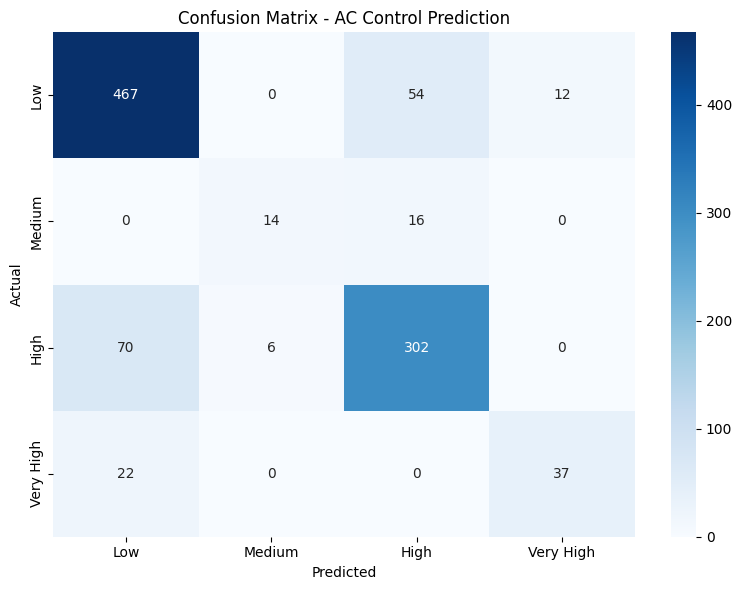


=== Classification Report ===
              precision    recall  f1-score   support

        High       0.84      0.88      0.86       533
         Low       0.70      0.47      0.56        30
      Medium       0.81      0.80      0.81       378
   Very High       0.76      0.63      0.69        59

    accuracy                           0.82      1000
   macro avg       0.78      0.69      0.73      1000
weighted avg       0.82      0.82      0.82      1000



In [5]:
### 1.4 Classification Metrics (After Binning)

# Calculate classification metrics
accuracy = accuracy_score(y_test_binned, y_pred_binned)
precision = precision_score(y_test_binned, y_pred_binned, average='weighted', zero_division=0)
recall = recall_score(y_test_binned, y_pred_binned, average='weighted', zero_division=0)
f1 = f1_score(y_test_binned, y_pred_binned, average='weighted', zero_division=0)

print("=== Classification Metrics (After Binning) ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binned, y_pred_binned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - AC Control Prediction')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('ac_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Classification Report ===")
print(classification_report(y_test_binned, y_pred_binned, zero_division=0))

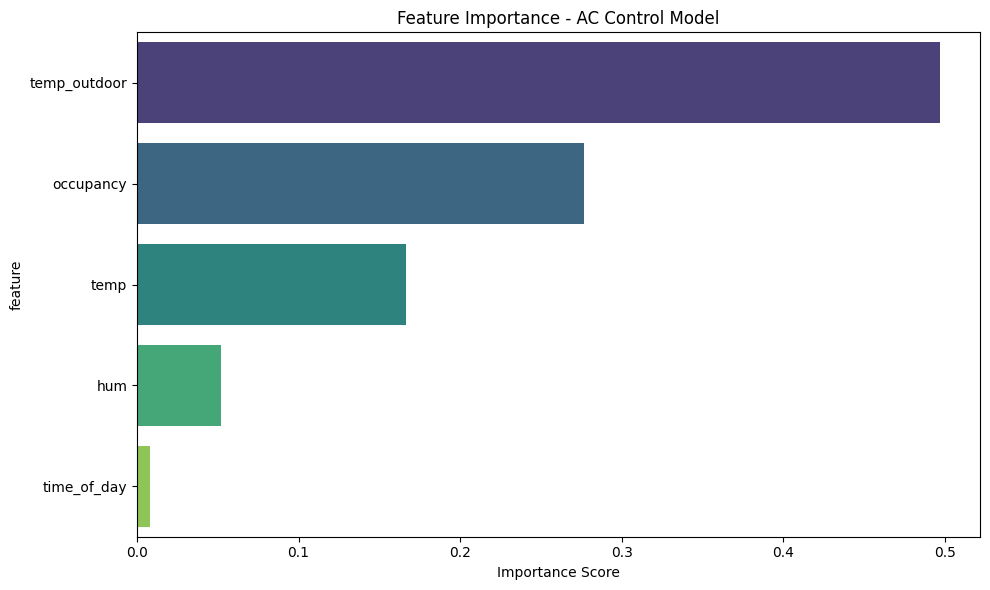

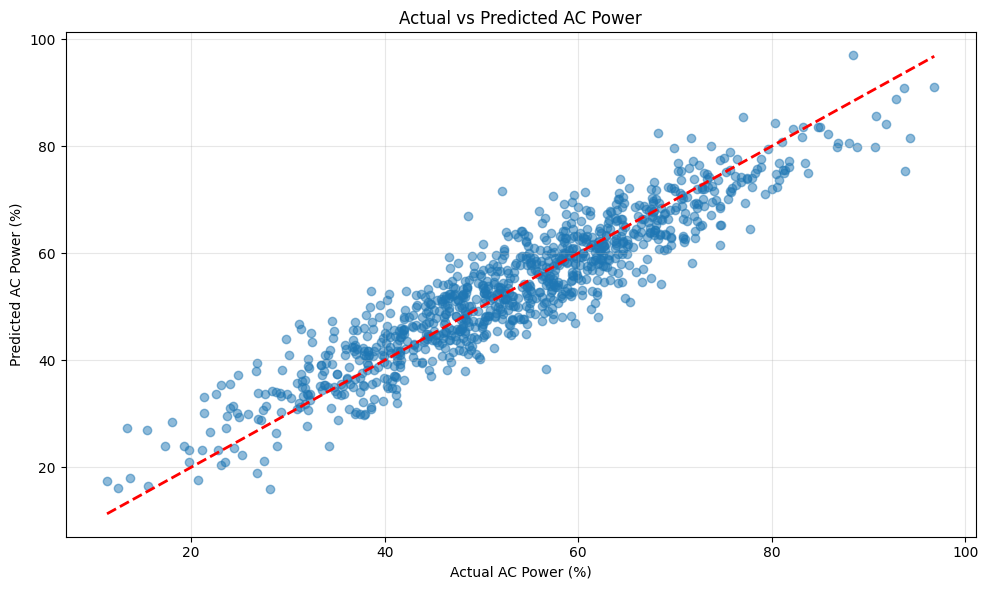

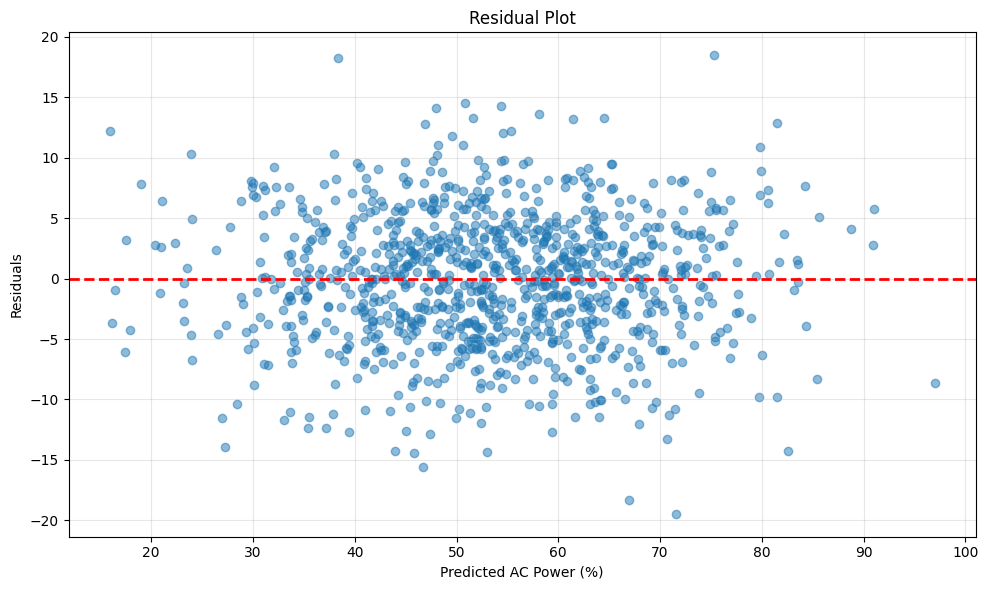

In [6]:
### 1.5 Visualizations

# Feature Importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - AC Control Model')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('ac_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Actual vs Predicted (Regression)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AC Power (%)')
plt.ylabel('Predicted AC Power (%)')
plt.title('Actual vs Predicted AC Power')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ac_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted AC Power (%)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ac_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
### 1.6 Save Model

# Save XGBoost model
with open('ac_control_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✓ AC Control Model saved as 'ac_control_model.pkl'")

# Test loading
with open('ac_control_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
# Quick test
test_input = pd.DataFrame({
    'temp': [25.0],
    'hum': [60.0],
    'temp_outdoor': [32.0],
    'occupancy': [5],
    'time_of_day': [14]
})

prediction = loaded_model.predict(test_input)
print(f"\n✓ Model test - Predicted AC Power: {prediction[0]:.2f}%")

✓ AC Control Model saved as 'ac_control_model.pkl'

✓ Model test - Predicted AC Power: 55.53%


---

## 2. Deteksi Anomali Kondisi Ruangan (Isolation Forest)

Subsistem ini menggunakan Isolation Forest untuk mendeteksi anomali pada kondisi ruangan BSL. Model ini memberikan early warning jika terdapat perubahan parameter yang tidak diharapkan, mencegah kegagalan operasional lab.

**Features:**
- `temp`: Suhu ruangan (°C)
- `hum`: Kelembaban relatif (%)
- `pressure_diff`: Tekanan diferensial (Pa)
- `co2_level`: Level CO2 (ppm)
- `voc_level`: Volatile Organic Compounds (ppb)

**Target:**
- `anomaly`: 0 = Normal, 1 = Anomaly

In [16]:
### 2.1 Import Dataset for Anomaly Detection
anomaly_data = pd.read_csv('anomaly_train.csv')
print("✓ Anomaly dataset imported successfully")

✓ Anomaly dataset imported successfully


In [9]:
### 2.2 Train Isolation Forest Model

# Split data
X_anomaly = anomaly_data.drop('anomaly', axis=1)
y_anomaly = anomaly_data['anomaly']

X_train_anom, X_test_anom, y_train_anom, y_test_anom = train_test_split(
    X_anomaly, y_anomaly, test_size=0.2, random_state=42, stratify=y_anomaly
)

# Train Isolation Forest
# contamination = expected proportion of anomalies (0.2 = 20%)
print("Training Isolation Forest model...")
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.2,  # Expected 20% anomalies
    random_state=42,
    n_jobs=-1
)

# Fit on training data
iso_forest.fit(X_train_anom)
print("✓ Model trained successfully")

# Predict on test data
# Isolation Forest returns: 1 for inliers (normal), -1 for outliers (anomaly)
y_pred_anom = iso_forest.predict(X_test_anom)

# Convert predictions: -1 → 1 (anomaly), 1 → 0 (normal)
y_pred_anom_binary = np.where(y_pred_anom == -1, 1, 0)

print(f"\nPrediction Distribution:")
print(f"Normal (0): {(y_pred_anom_binary==0).sum()}")
print(f"Anomaly (1): {(y_pred_anom_binary==1).sum()}")

Training Isolation Forest model...
✓ Model trained successfully

Prediction Distribution:
Normal (0): 824
Anomaly (1): 176


=== Classification Metrics ===
Accuracy:  0.9260
Precision: 0.8580
Recall:    0.7550
F1-Score:  0.8032


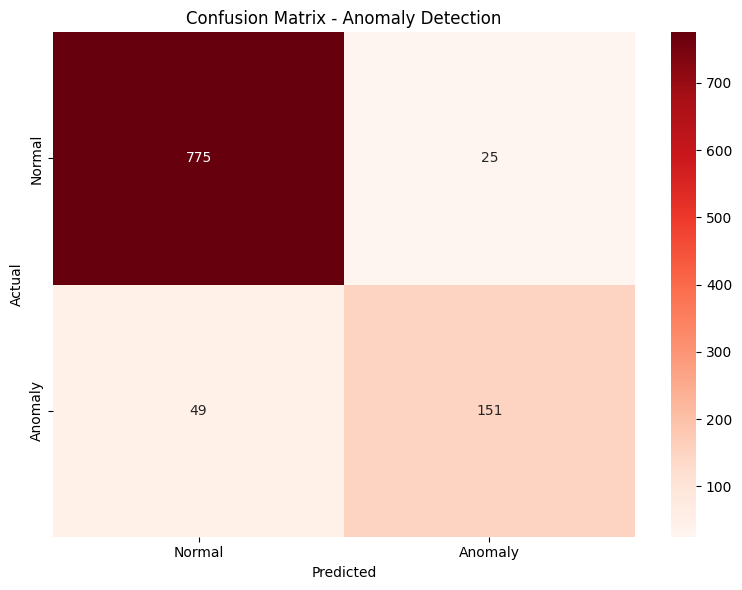


=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       800
     Anomaly       0.86      0.76      0.80       200

    accuracy                           0.93      1000
   macro avg       0.90      0.86      0.88      1000
weighted avg       0.92      0.93      0.92      1000



In [10]:
### 2.3 Evaluation Metrics

# Calculate classification metrics
accuracy_anom = accuracy_score(y_test_anom, y_pred_anom_binary)
precision_anom = precision_score(y_test_anom, y_pred_anom_binary, zero_division=0)
recall_anom = recall_score(y_test_anom, y_pred_anom_binary, zero_division=0)
f1_anom = f1_score(y_test_anom, y_pred_anom_binary, zero_division=0)

print("=== Classification Metrics ===")
print(f"Accuracy:  {accuracy_anom:.4f}")
print(f"Precision: {precision_anom:.4f}")
print(f"Recall:    {recall_anom:.4f}")
print(f"F1-Score:  {f1_anom:.4f}")

# Confusion Matrix
cm_anom = confusion_matrix(y_test_anom, y_pred_anom_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_anom, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - Anomaly Detection')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('anomaly_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Classification Report ===")
print(classification_report(y_test_anom, y_pred_anom_binary, 
                          target_names=['Normal', 'Anomaly'],
                          zero_division=0))

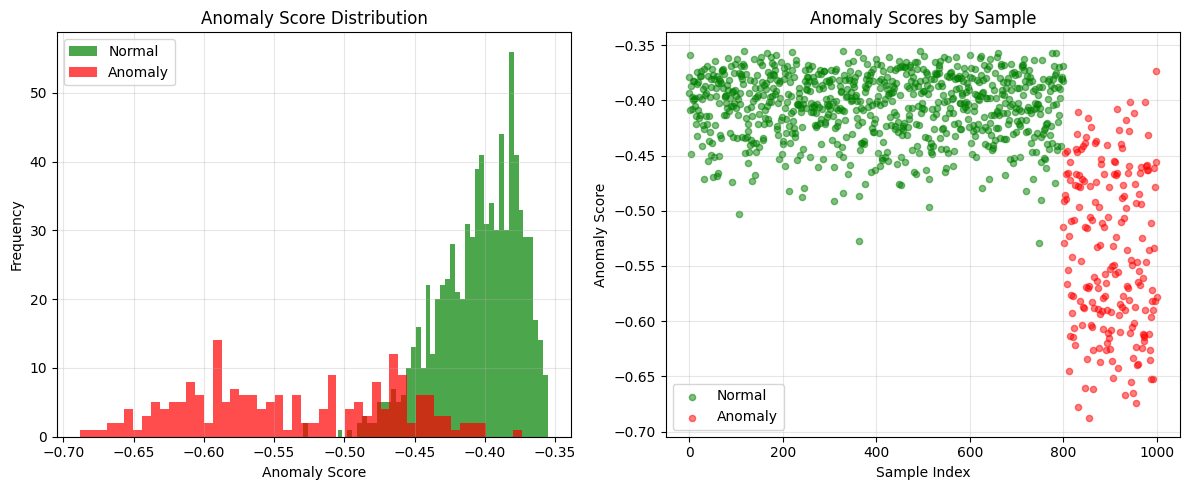

In [11]:
### 2.4 Anomaly Score Distribution

# Get anomaly scores (lower = more anomalous)
scores = iso_forest.score_samples(X_test_anom)

plt.figure(figsize=(12, 5))

# Plot 1: Anomaly Score Distribution
plt.subplot(1, 2, 1)
plt.hist(scores[y_test_anom == 0], bins=50, alpha=0.7, label='Normal', color='green')
plt.hist(scores[y_test_anom == 1], bins=50, alpha=0.7, label='Anomaly', color='red')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Scatter plot of scores
plt.subplot(1, 2, 2)
normal_indices = y_test_anom == 0
anomaly_indices = y_test_anom == 1

plt.scatter(range(len(scores[normal_indices])), scores[normal_indices], 
           alpha=0.5, label='Normal', color='green', s=20)
plt.scatter(range(len(scores[normal_indices]), len(scores)), scores[anomaly_indices],
           alpha=0.5, label='Anomaly', color='red', s=20)
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Scores by Sample')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_scores.png', dpi=150, bbox_inches='tight')
plt.show()

=== Feature Analysis ===

Mean values comparison (Normal vs Anomaly):
                     Feature  Normal Mean  Anomaly Mean  Difference
co2_level          co2_level   798.898221   1086.833432  287.935211
voc_level          voc_level   200.424264    377.250172  176.825908
pressure_diff  pressure_diff   -15.013741     -9.549094    5.464647
hum                      hum    54.869977     59.282594    4.412617
temp                    temp    24.014364     27.287098    3.272734


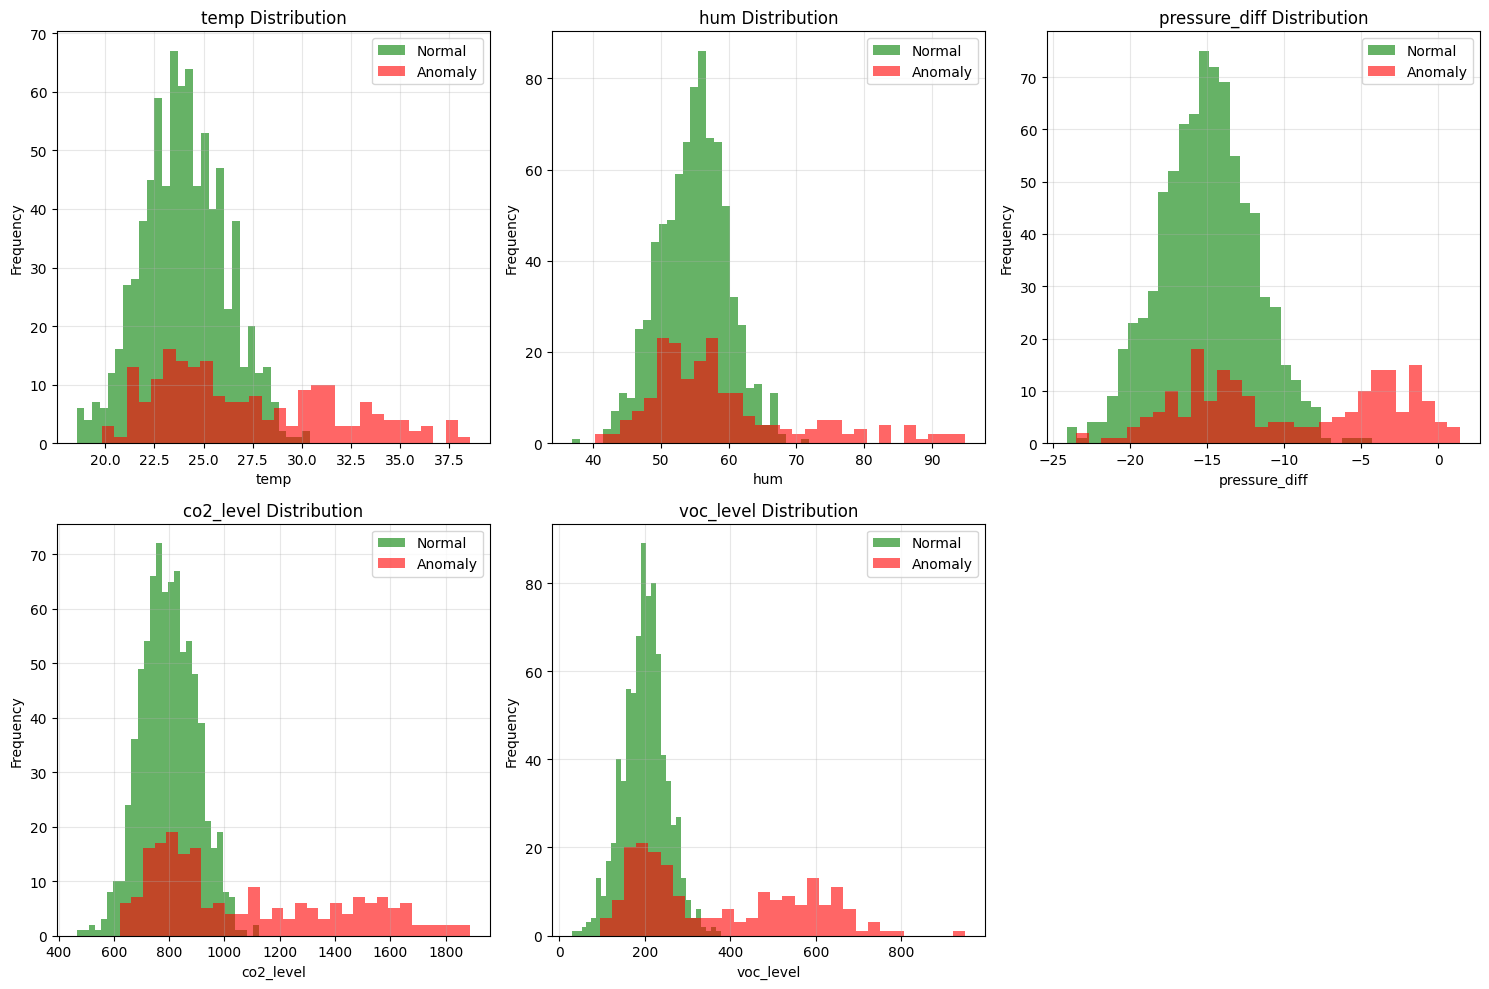

In [12]:
### 2.5 Feature Analysis

# Analyze which features contribute most to anomalies
# Calculate mean feature values for normal vs anomaly cases
normal_data = X_test_anom[y_test_anom == 0]
anomaly_detected = X_test_anom[y_test_anom == 1]

comparison = pd.DataFrame({
    'Feature': X_anomaly.columns,
    'Normal Mean': normal_data.mean(),
    'Anomaly Mean': anomaly_detected.mean(),
    'Difference': abs(anomaly_detected.mean() - normal_data.mean())
}).sort_values('Difference', ascending=False)

print("=== Feature Analysis ===")
print("\nMean values comparison (Normal vs Anomaly):")
print(comparison)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(X_anomaly.columns):
    ax = axes[idx]
    ax.hist(normal_data[feature], bins=30, alpha=0.6, label='Normal', color='green')
    ax.hist(anomaly_detected[feature], bins=30, alpha=0.6, label='Anomaly', color='red')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature} Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('anomaly_feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
### 2.6 Save Model

# Save Isolation Forest model
with open('anomaly_detection_model.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)

print("✓ Anomaly Detection Model saved as 'anomaly_detection_model.pkl'")

# Test loading
with open('anomaly_detection_model.pkl', 'rb') as f:
    loaded_iso_forest = pickle.load(f)

# Quick test with normal conditions
test_normal = pd.DataFrame({
    'temp': [24.0],
    'hum': [55.0],
    'pressure_diff': [-15.0],
    'co2_level': [800.0],
    'voc_level': [200.0]
})

prediction_normal = loaded_iso_forest.predict(test_normal)
score_normal = loaded_iso_forest.score_samples(test_normal)
print(f"\n✓ Normal condition test - Prediction: {prediction_normal[0]} (1=Normal, -1=Anomaly)")
print(f"  Anomaly Score: {score_normal[0]:.4f}")

# Quick test with anomaly conditions
test_anomaly = pd.DataFrame({
    'temp': [32.0],  # High temperature
    'hum': [75.0],   # High humidity
    'pressure_diff': [-2.0],  # Loss of negative pressure
    'co2_level': [1500.0],  # High CO2
    'voc_level': [600.0]   # High VOC
})

prediction_anomaly = loaded_iso_forest.predict(test_anomaly)
score_anomaly = loaded_iso_forest.score_samples(test_anomaly)
print(f"\n✓ Anomaly condition test - Prediction: {prediction_anomaly[0]} (1=Normal, -1=Anomaly)")
print(f"  Anomaly Score: {score_anomaly[0]:.4f}")

✓ Anomaly Detection Model saved as 'anomaly_detection_model.pkl'

✓ Normal condition test - Prediction: 1 (1=Normal, -1=Anomaly)
  Anomaly Score: -0.3520

✓ Anomaly condition test - Prediction: -1 (1=Normal, -1=Anomaly)
  Anomaly Score: -0.6447


---

## Summary

### Models Generated:
1. **ac_control_model.pkl** - XGBoost Regressor for AC power prediction
2. **anomaly_detection_model.pkl** - Isolation Forest for room condition anomaly detection

### Training Data Generated:
1. **ac_control_train.csv** - 5000 samples for AC control training
2. **anomaly_train.csv** - 5000 samples for anomaly detection training

### Model Performance:

#### AC Control Model:
- Uses XGBoost regression with binning for efficient AC power control
- Features: temperature, humidity, outdoor temp, occupancy, time of day
- Output: AC power percentage (0-100%) binned into 4 categories
- Minimizes noise by updating commands every 1 minute

#### Anomaly Detection Model:
- Uses Isolation Forest for unsupervised anomaly detection
- Features: temperature, humidity, pressure differential, CO2, VOC levels
- Detects: temperature spikes, pressure failures, ventilation issues, multiple failures
- Provides early warning system for lab safety

### Usage in Python Server:

```python
import pickle
import pandas as pd

# Load models
with open('ac_control_model.pkl', 'rb') as f:
    ac_model = pickle.load(f)
    
with open('anomaly_detection_model.pkl', 'rb') as f:
    anomaly_model = pickle.load(f)

# Predict AC power
sensor_data = pd.DataFrame({
    'temp': [25.0],
    'hum': [60.0],
    'temp_outdoor': [32.0],
    'occupancy': [5],
    'time_of_day': [14]
})
ac_power = ac_model.predict(sensor_data)[0]

# Detect anomaly
room_data = pd.DataFrame({
    'temp': [24.0],
    'hum': [55.0],
    'pressure_diff': [-15.0],
    'co2_level': [800.0],
    'voc_level': [200.0]
})
is_anomaly = anomaly_model.predict(room_data)[0]  # 1=Normal, -1=Anomaly
anomaly_score = anomaly_model.score_samples(room_data)[0]
```